In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
from healpy.newvisufunc import projview
import itertools as it
import fitsio
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
import time
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools
from dipole_object import DipoleObject
import dipole
import ellisbaldwin
from jackknife import get_longitude_subsamples_from_hpmap, compute_jackknife_uncertainty, covar_jackknife
from multipoles import compute_Cells_from_alms_fit

### functions

In [3]:
def measure_dipole_in_overdensity_map(sample, selfunc=None, Wmask=0.1):
    map_to_fit = sample.copy()
    idx_masked = np.isnan(map_to_fit)
    map_to_fit[idx_masked] = 0.
    Cinv = np.ones_like(sample) if np.all(selfunc == None) else selfunc.copy()
    Cinv[idx_masked] = Wmask
    amps, stderr = dipole.fit_dipole(map_to_fit, Cinv=Cinv, fit_zeros=True)
    return amps[1:] # since we're fitting overdensities

In [4]:
def Cells_from_alms_fit(overdensity_map, Wmask, max_ell, return_alms=False, selfunc=None):
    # wrapper for compute_Cells_from_alms_fit() but taking an overdensity map as input,
    #  to replace all NaN pixels with 0 data and Wmask Cinv
    map_to_fit = overdensity_map.copy()
    idx_masked = np.isnan(map_to_fit)
    map_to_fit[idx_masked] = 0.
    Cinv = np.ones_like(map_to_fit) if np.all(selfunc == None) else selfunc.copy()
    Cinv[idx_masked] = Wmask
    return compute_Cells_from_alms_fit(map_to_fit, Cinv, max_ell, return_alms=return_alms)

### CatWISE quasar sample

In [5]:
# instantiate a dipole object and load the source density table - NOT corrected by the selection function
d = DipoleObject(initial_catfn='catwise_agns_master.fits', catname='catwise_agns', mag='w1',
                    blim=30, maglim=16.4, load_init=True)
d.cut_galactic_plane()

# delete the initial table to clear up memory !
del d.initial_cattab

# expected dipole amplitude:
expected_dipole_res = ellisbaldwin.compute_expected_dipole_wise(d.table, maglimit=d.maglim, min_w1=15.8, max_w1=16.8,
                                                   verbose=True, return_full_results=True)
expected_dipamp = expected_dipole_res['expected_dipamp']
# now make the magnitude cut 
d.cut_mag()

loading initial catalog, catwise_agns_master.fits
8532854 sources in initial catalog.
cut |b| <= 30 -> 4479160 sources left.
number-count slope x = 1.748
effective alpha = 1.270
expected dipole amplitude = 0.0074
cut w1 > 16.4 -> 1400045 sources left.


Text(0.5, 0.98, 'CatWISE W1<16.4 Ellis-Baldwin parameters')

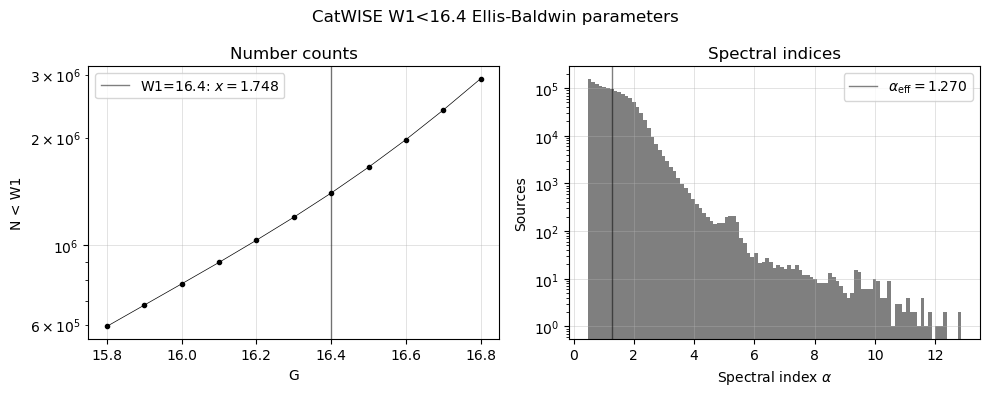

In [6]:
# plot the parameters
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4), tight_layout=True)

mags, counts, x = expected_dipole_res['mag_grid'], expected_dipole_res['counts'], expected_dipole_res['x']
ax0.plot(mags, counts, 'k.-', lw=0.5)
ax0.axvline(d.maglim, color='k', alpha=0.5, lw=1, label=f'W1={d.maglim}: 'r'$x=$'f'{x:.3f}')
ax0.set_xlabel('G')
ax0.set_ylabel('N < W1')
ax0.set_title('Number counts')

alpha, alphas = expected_dipole_res['alpha'], expected_dipole_res['alphas']
_, _, _ = ax1.hist(alphas, bins=101, alpha=0.5, color='k')
ax1.axvline(alpha, color='k', alpha=0.5, lw=1, label=r'$\alpha_\mathrm{eff}=$'f'{alpha:.3f}')
ax1.set_xlabel(r'Spectral index $\alpha$')
ax1.set_ylabel(r'Sources')
ax1.set_title('Spectral indices')

for ax in (ax0, ax1):
    ax.grid(lw=0.5, alpha=0.5)
    ax.semilogy()
    ax.legend()
fig.suptitle(f'CatWISE W1<{d.maglim} Ellis-Baldwin parameters')

#### construct overdensity maps

In [7]:
# MASKS
# mask the galactic plane (mask pixels based on their central sky coordinate)
lon, lat = hp.pix2ang(d.NSIDE, np.arange(hp.nside2npix(d.NSIDE)), lonlat=True)
b = SkyCoord(lon * u.deg, lat * u.deg, frame='icrs').galactic.b
gal_plane_mask = np.zeros(hp.nside2npix(d.NSIDE))
gal_plane_mask[np.abs(b.deg) >= d.blim] = 1

# load smaller masks (used in S21): at the pixel level
small_masks = fitsio.read(d.mask_fn)
assert len(small_masks) == len(gal_plane_mask) == hp.nside2npix(d.NSIDE)

# total mask: galactic plane and smaller masks
mask = gal_plane_mask.astype(bool) & small_masks.astype(bool)

In [8]:
# OVERDENSITY MAP, NO selection function (i.e. assume completeness = 1 everywhere)
# turn astropy table into healpix map
datamap = tools.load_catalog_as_map(d.table, NSIDE=d.NSIDE)
# mask the data: populate a nan map with the data values in unmasked pixels
masked_datamap = np.multiply(datamap, mask, where=(mask!=0), out=np.full_like(datamap, np.nan))
# then the overdensity map is
overdensity_map = masked_datamap / np.nanmean(masked_datamap) - 1

In [9]:
# OVERDENSITY MAP, WITH SELECTION FUNCTION
# load selection function
selfunc = d.load_selfunc(selfunc_fn=os.path.join(d.catdir, 'selfuncs', f'selection_function_NSIDE64_catwise_pluszodis.fits'))
# new total mask: galactic plane, smaller masks, and where completeness < 0.5
mask = gal_plane_mask.astype(bool) & small_masks.astype(bool) & (selfunc > 0.5)

# mask the data with the updated mask:
masked_datamap = np.multiply(datamap, mask, where=(mask!=0), out=np.full_like(datamap, np.nan))
# mean density of the map: mean of the _expected_ counts
mean_density = np.nanmean(masked_datamap / selfunc)
# then the overdensity map is
overdensity_map_selfunc = np.divide(masked_datamap, selfunc, where=mask,
                                out=np.full_like(masked_datamap, np.nan)) / mean_density - 1
                        # (fancy divide to avoid RuntimeWarnings where completeness goes to zero)

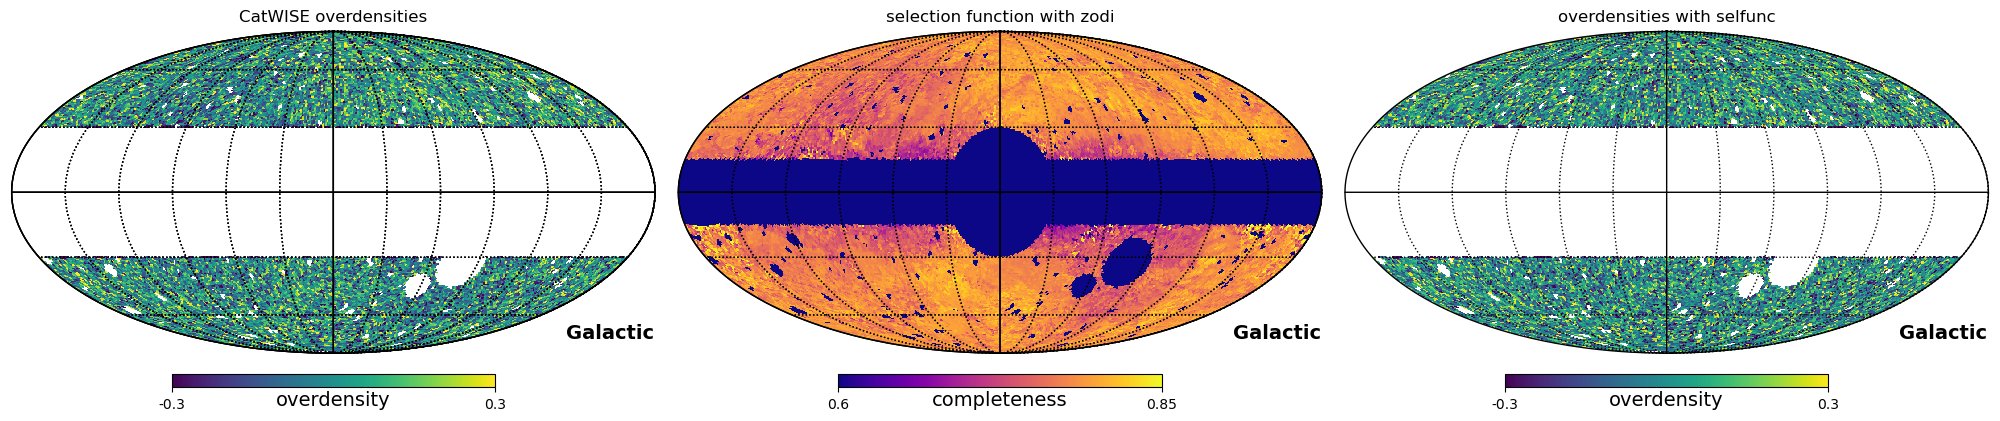

In [10]:
# plot maps to compare:
fig = plt.figure(figsize=(20,4))
kwargs = dict(fig=fig, coord=['C','G'], badcolor='w')
hp.mollview(overdensity_map, sub=(1,3,1), title=r'CatWISE overdensities', min=-0.3, max=0.3, unit='overdensity', **kwargs)
hp.graticule()
hp.mollview(selfunc, sub=(1,3,2), title=r'selection function with zodi', min=0.6, max=0.85, unit='completeness', cmap='plasma', **kwargs)
hp.graticule()
hp.mollview(overdensity_map_selfunc, sub=(1,3,3), title=r'overdensities with selfunc', min=-0.3, max=0.3, unit='overdensity', **kwargs)
hp.graticule()

#### also compare to ecliptic-latitude-density-corrected map

In [11]:
# ecliptic latitudes of each HEALPIXEL
elat = SkyCoord(lon * u.deg, lat * u.deg, frame='icrs').geocentrictrueecliptic.lat
# fit a line: density vs elat
idx = ~np.isnan(elat) & ~np.isnan(masked_datamap)
p = np.polyfit(np.abs(elat)[idx], masked_datamap[idx], deg=1)

# correct the densities and fit to the corrected densities
map_elatcorr = masked_datamap - np.polyval(p, np.abs(elat.value)) + p[1]
p_corr = np.polyfit(np.abs(elat)[idx], map_elatcorr[idx], deg=1)

# then the overdensity map is
overdensity_map_elat = map_elatcorr / np.nanmean(map_elatcorr) - 1

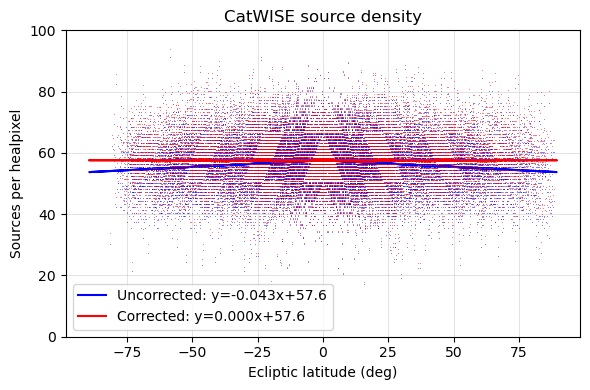

In [14]:
# plot before/after the correction
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
# uncorrected
ax.plot(elat, masked_datamap, ls='None', marker=',', c='b', alpha=0.5)
# above the plane
ax.plot(elat[elat.value>0], elat.value[elat.value>0] * p[0] + p[1], c='b',
        label=f'Uncorrected: y={p[0]:.3f}x+{p[1]:.1f}')
# below the plane
ax.plot(elat[elat.value<0], - elat.value[elat.value<0] * p[0] + p[1], c='b')
# corrected
ax.plot(elat, map_elatcorr, ls='None', marker=',', c='r', alpha=0.5)
# above the plane
ax.plot(elat[elat.value>0], elat.value[elat.value>0] * p_corr[0] + p_corr[1], c='r',
        label=f'Corrected: y={p_corr[0]:.3f}x+{p_corr[1]:.1f}')
# below the plane
ax.plot(elat[elat.value<0], - elat.value[elat.value<0] * p_corr[0] + p_corr[1], c='r')

ax.grid(alpha=0.5, lw=0.5)
ax.set_ylim(0, 100)
ax.set_xlabel('Ecliptic latitude (deg)')
ax.set_ylabel('Sources per healpixel')
ax.set_title('CatWISE source density')
ax.legend()

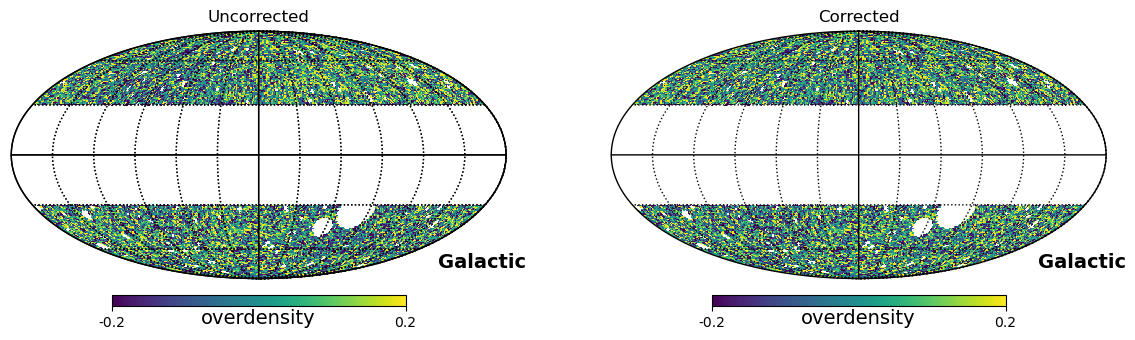

In [15]:
# check overdensity maps before and after
fig = plt.figure(figsize=(12,3))
kwargs = dict(coord=['C','G'], fig=fig, unit='overdensity', min=-.2, max=.2, badcolor='w')
hp.mollview(overdensity_map, sub=(1,2,1), title='Uncorrected', **kwargs)
hp.graticule()
hp.mollview(overdensity_map_elat, sub=(1,2,2), title='Corrected', **kwargs)
hp.graticule()

#### jackknife subsamples

In [16]:
nsamples = 12
lonavg, subsamples = get_longitude_subsamples_from_hpmap(overdensity_map, nsamples, input_frame='icrs')
lonavg, subsamples_sf = get_longitude_subsamples_from_hpmap(overdensity_map_selfunc, nsamples, input_frame='icrs')
lonavg, subsamples_elat = get_longitude_subsamples_from_hpmap(overdensity_map_elat, nsamples, input_frame='icrs')
jk_subsamples = [subsamples, subsamples_sf, subsamples_elat]

#### measure dipoles

In [17]:
print("without selection function:")
dipole_comps = measure_dipole_in_overdensity_map(overdensity_map)
dipole_amp, dipole_dir = dipole.get_dipole(dipole_comps)
print(f"\tbest-fit dipole amp. =\t{dipole_amp:.5f}")
print(f"\texpected dipole amp. =\t{expected_dipamp:.5f}\n\tratio =\t\t\t{dipole_amp / expected_dipamp:.4f}")
print("with selection function:")
dipole_comps_sf = measure_dipole_in_overdensity_map(overdensity_map_selfunc)
dipole_amp_sf, dipole_dir_sf = dipole.get_dipole(dipole_comps_sf)
print(f"\tbest-fit dipole amp. =\t{dipole_amp_sf:.5f}")
print(f"\texpected dipole amp. =\t{expected_dipamp:.5f}\n\tratio =\t\t\t{dipole_amp_sf / expected_dipamp:.4f}")
print("with elat density correction:")
dipole_comps_elat = measure_dipole_in_overdensity_map(overdensity_map_elat)
dipole_amp_elat, dipole_dir_elat = dipole.get_dipole(dipole_comps_elat)
print(f"\tbest-fit dipole amp. =\t{dipole_amp_elat:.5f}")
print(f"\texpected dipole amp. =\t{expected_dipamp:.5f}\n\tratio =\t\t\t{dipole_amp_elat / expected_dipamp:.4f}")

without selection function:
	best-fit dipole amp. =	0.01476
	expected dipole amp. =	0.00736
	ratio =			2.0059
with selection function:
	best-fit dipole amp. =	0.01089
	expected dipole amp. =	0.00736
	ratio =			1.4801
with elat density correction:
	best-fit dipole amp. =	0.01338
	expected dipole amp. =	0.00736
	ratio =			1.8175


In [18]:
# jackknife uncertainties
jk_uncertainties = np.empty((len(jk_subsamples),2))
for i, sample in enumerate(jk_subsamples):
    jk_uncertainty, dipole_comps = compute_jackknife_uncertainty(sample, measure_dipole_in_overdensity_map, return_outputs=True)
    avg_comps = np.nanmean(dipole_comps, axis=0)
    avg_comps_norm = avg_comps / np.sqrt(avg_comps @ avg_comps)
    angular_dist = np.rad2deg(np.array([
        np.arccos((comps @ avg_comps_norm) / np.sqrt(comps @ comps)) for comps in dipole_comps
    ])) # in degrees
    # uncertainties
    std_amp = np.linalg.norm(jk_uncertainty)
    std_dist = np.sqrt(np.diag(covar_jackknife(angular_dist)))[0]  # index 0 because this is a list of length 1
    jk_uncertainties[i] = (std_amp, std_dist)

Text(0.5, 1.0, 'CatWISE measured dipole directions')

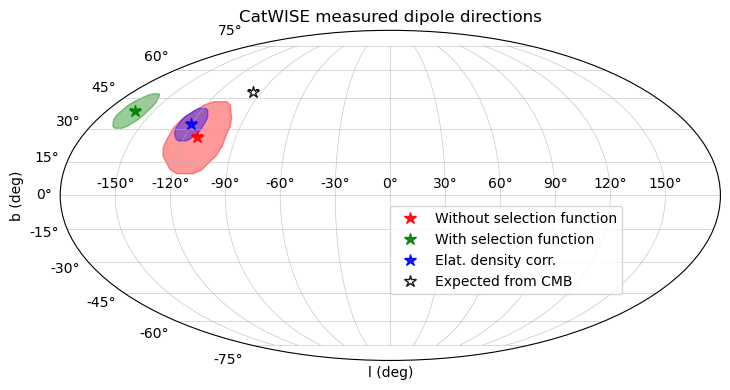

In [19]:
# plot directions
fig = plt.figure(figsize=(8,4), tight_layout=True)
ax = plt.subplot(111, projection='mollweide')
kwargs = dict(marker='*', ms=9, ls='None', alpha=0.9)

# without selection function:
# 1sigma uncertainty contours
circ = mpl.patches.Circle((Angle(dipole_dir.galactic.l).to(u.rad).wrap_at(np.pi*u.rad).value,
                            Angle(dipole_dir.galactic.b).to(u.rad).wrap_at(np.pi*u.rad).value),
                              radius=(jk_uncertainties[0,1]*u.deg).to(u.rad).value, color='r', alpha=0.4)
ax.add_artist(circ)
ax.plot(Angle(dipole_dir.galactic.l).to(u.rad).wrap_at(np.pi*u.rad),
        Angle(dipole_dir.galactic.b).to(u.rad).wrap_at(np.pi*u.rad),
        c='r', label=r'Without selection function', **kwargs)
# with selection function:
circ = mpl.patches.Circle((Angle(dipole_dir_sf.galactic.l).to(u.rad).wrap_at(np.pi*u.rad).value,
                            Angle(dipole_dir_sf.galactic.b).to(u.rad).wrap_at(np.pi*u.rad).value),
                              radius=(jk_uncertainties[1,1]*u.deg).to(u.rad).value, color='g', alpha=0.4)
ax.add_artist(circ)
ax.plot(Angle(dipole_dir_sf.galactic.l).to(u.rad).wrap_at(np.pi*u.rad),
        Angle(dipole_dir_sf.galactic.b).to(u.rad).wrap_at(np.pi*u.rad),
        c='g', label=r'With selection function', **kwargs)
# with elat density correction:
circ = mpl.patches.Circle((Angle(dipole_dir_elat.galactic.l).to(u.rad).wrap_at(np.pi*u.rad).value,
                            Angle(dipole_dir_elat.galactic.b).to(u.rad).wrap_at(np.pi*u.rad).value),
                              radius=(jk_uncertainties[2,1]*u.deg).to(u.rad).value, color='b', alpha=0.4)
ax.add_artist(circ)
ax.plot(Angle(dipole_dir_elat.galactic.l).to(u.rad).wrap_at(np.pi*u.rad),
        Angle(dipole_dir_elat.galactic.b).to(u.rad).wrap_at(np.pi*u.rad),
        c='b', label=r'Elat. density corr.', **kwargs)
# CMB
cmb_dir = dipole.cmb_dipole()[1].galactic
ax.plot(Angle(cmb_dir.l, unit=u.rad).wrap_at(np.pi*u.rad),
        Angle(cmb_dir.b, unit=u.rad).wrap_at(np.pi*u.rad),
        c='None', mec='k', label='Expected from CMB', **kwargs)

ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
ax.legend(loc=(0.5,0.2))
ax.grid(True, lw=0.5, alpha=0.7)
ax.set_title('CatWISE measured dipole directions')

### measure Cells

In [20]:
max_ell = 4
Wmask = 0.1

In [21]:
# define function for jackknife: output needs to be just the Cells, to compute the uncertainty
def Cells_for_jk(overdensity_map, Wmask, max_ell, selfunc=None):
    ells, Cells = Cells_from_alms_fit(overdensity_map, Wmask, max_ell, selfunc=selfunc)
    return Cells

In [26]:
# WITHOUT selection function
ells, Cells = Cells_from_alms_fit(overdensity_map, Wmask, max_ell)
# jackknife
Cells_std = compute_jackknife_uncertainty(subsamples, Cells_for_jk, Wmask=Wmask, max_ell=max_ell)

ValueError: not enough values to unpack (expected 3, got 2)

In [27]:
# WITH selection function
ells, Cells_sf = Cells_from_alms_fit(overdensity_map_selfunc, Wmask, max_ell)
# jackknife
Cells_std_sf = compute_jackknife_uncertainty(subsamples_sf, Cells_for_jk, Wmask=Wmask, max_ell=max_ell)

# with elat density correction:
ells, Cells_elat = Cells_from_alms_fit(overdensity_map_elat, Wmask, max_ell)
# jackknife
Cells_std_elat = compute_jackknife_uncertainty(subsamples_elat, Cells_for_jk, Wmask=Wmask, max_ell=max_ell)

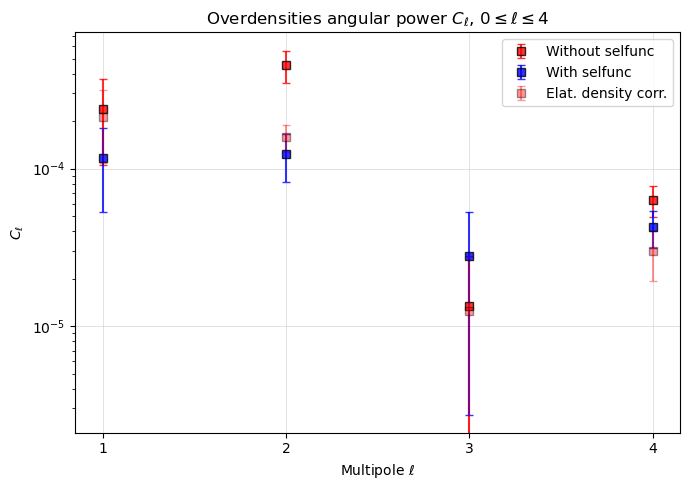

In [28]:
# plottt
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
kwargs = dict(ls='None', mec='k', ms=6, marker='s', capsize=3)
ax.errorbar(ells[1:], Cells[1:], yerr=Cells_std[1:], label='Without selfunc', c='r', alpha=0.8, **kwargs)
ax.errorbar(ells[1:], Cells_sf[1:], yerr=Cells_std_sf[1:], label='With selfunc', c='b', alpha=0.8, **kwargs)
ax.errorbar(ells[1:], Cells_elat[1:], yerr=Cells_std_elat[1:], label='Elat. density corr.', c='r', alpha=0.4, **kwargs)

ax.semilogy()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_xticks(np.arange(1, max(ells)+1))
ax.set_ylabel(r'$C_\ell$')
ax.set_title(r'Overdensities angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
ax.legend()

In [89]:
# WITHOUT selection function
# map to fit: zero in the masked pixels
map_to_fit = overdensity_map.copy()
idx_masked = np.isnan(map_to_fit)
map_to_fit[idx_masked] = 0.
# Cinv: completeness in unmasked, Wmask in the masked pixels
Cinv_ = np.ones_like(map_to_fit)
Cinv_[idx_masked] = Wmask
ells, Cells, alms = compute_Cells_from_alms_fit(map_to_fit, Cinv_, max_ell, return_alms=True)

# WITH selection function
# map to fit: zero in the masked pixels
map_to_fit = overdensity_map_selfunc.copy()
idx_masked = np.isnan(map_to_fit)
map_to_fit[idx_masked] = 0.
# Cinv: completeness in unmasked, Wmask in the masked pixels
Cinv_ = selfunc
Cinv_[idx_masked] = Wmask
ells, Cells_sf, alms_sf = compute_Cells_from_alms_fit(map_to_fit, Cinv_, max_ell, return_alms=True)

# with elat density correction:
map_to_fit = overdensity_map_elat.copy()
idx_masked = np.isnan(map_to_fit)
map_to_fit[idx_masked] = 0.
Cinv_ = np.ones_like(map_to_fit)
Cinv_[idx_masked] = Wmask
ells, Cells_elat, alms_elat = compute_Cells_from_alms_fit(map_to_fit, Cinv_, max_ell, return_alms=True)

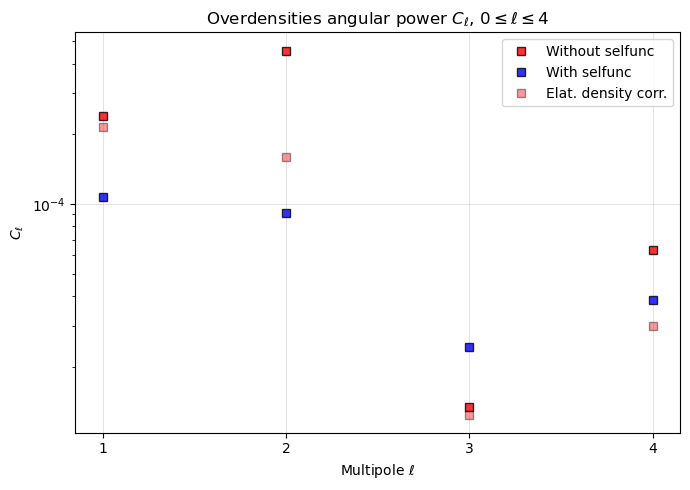

In [90]:
# plottt
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
kwargs = dict(ls='None', mec='k', ms=6)
ax.plot(ells[1:], Cells[1:], marker='s', label='Without selfunc', c='r', alpha=0.8, **kwargs)
ax.plot(ells[1:], Cells_sf[1:], marker='s', label='With selfunc', c='b', alpha=0.8, **kwargs)
ax.plot(ells[1:], Cells_elat[1:], marker='s', label='Elat. density corr.', c='r', alpha=0.4, **kwargs)

ax.semilogy()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_xticks(np.arange(1, max(ells)+1))
ax.set_ylabel(r'$C_\ell$')
ax.set_title(r'Overdensities angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
ax.legend()